## **PROYECTO MÓDULO 3: Optimización de Talento**

### **FASE 3: Visualización**

##### **Preparación previa del df:**

In [1]:
#Importar librerías
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
# Creamos una lista de colores corporativos para utilizar en las gráficas

colores_proyecto = [
    'mediumpurple',   # morado medio
    'darkorange',     # naranja fuerte
    'plum',           # morado claro
    'sandybrown',     # naranja suave
    'purple',         # morado intenso
    'lightsalmon',    # naranja rosado
    'orchid',         # morado rosado
    'chocolate'       # naranja oscuro
]

In [3]:
#Configuración de la visualización del DataFrame
pd.set_option('display.max_rows', None) # Deslimita visualización de filas
pd.set_option('display.max_columns', None) # Deslimita visualización de columnas

In [4]:
#Lectura del CSV y transformación a DataFrame (df)
df=pd.read_csv("HR_RAW_v3.csv", index_col =0)
df.sample(5)

,ID,Estado,Género,Edad,Año nac.,Estado civil,Nivel estudios,Área estudios,Frecuencia viaje,Distancia casa,Teletrabajo,Jornada,Formaciones (últ. año),Trabajos previos,Años activo,Antigüedad,Años desde ascenso,Años mismo jefe,Departamento,Categoría,Puesto,Horas extra,Evaluación,€/hora,€/día,€/mes,Ingreso mensual,% aumento salario,Acciones empresa,Compromiso,Satisf. global,Satisf. trabajo,Satisf. relaciones,Satisf. conciliación
1480,0,Activo,Hombre,43,1980,NS/NC,3,Otro,No viaja,31,Sí,Media jornada,3,1,11,25,3,9,Sin asignar,4,Director/a de investigación,No,3,0.0,982.0,4345.0,4859.0,11,1,2,1,2,3,3
1295,0,Activo,Hombre,28,1995,NS/NC,2,Otro,Viaja raramente,44,No,Jornada completa,2,1,10,10,1,8,Sin asignar,2,Técnico/a de laboratorio,No,3,79.0,1300.0,13535.0,4558.0,12,1,3,3,1,4,3
1075,1580,Activo,Hombre,34,1989,NS/NC,4,Otro,No viaja,2,Sí,Jornada completa,3,9,11,2,2,1,Investigación y desarrollo,2,Científico/a de investigación,No,3,45.0,1351.0,13008.0,4859.0,17,1,3,2,4,2,2
794,2052,Activo,Mujer,35,1988,Casado/a,4,Otro,Viaja raramente,2,Sí,Jornada completa,5,1,4,4,1,1,Sin asignar,1,Científico/a de investigación,No,3,62.0,287.0,8952.0,4859.0,12,1,1,3,4,4,3
704,0,Desvinculado,Mujer,24,1999,NS/NC,3,Otro,Viaja frecuentemente,18,Sí,Media jornada,4,1,6,6,1,2,Investigación y desarrollo,1,Técnico/a de laboratorio,No,3,55.0,1287.0,14168.0,4859.0,16,1,3,1,3,4,3


##### **Gráficos:**

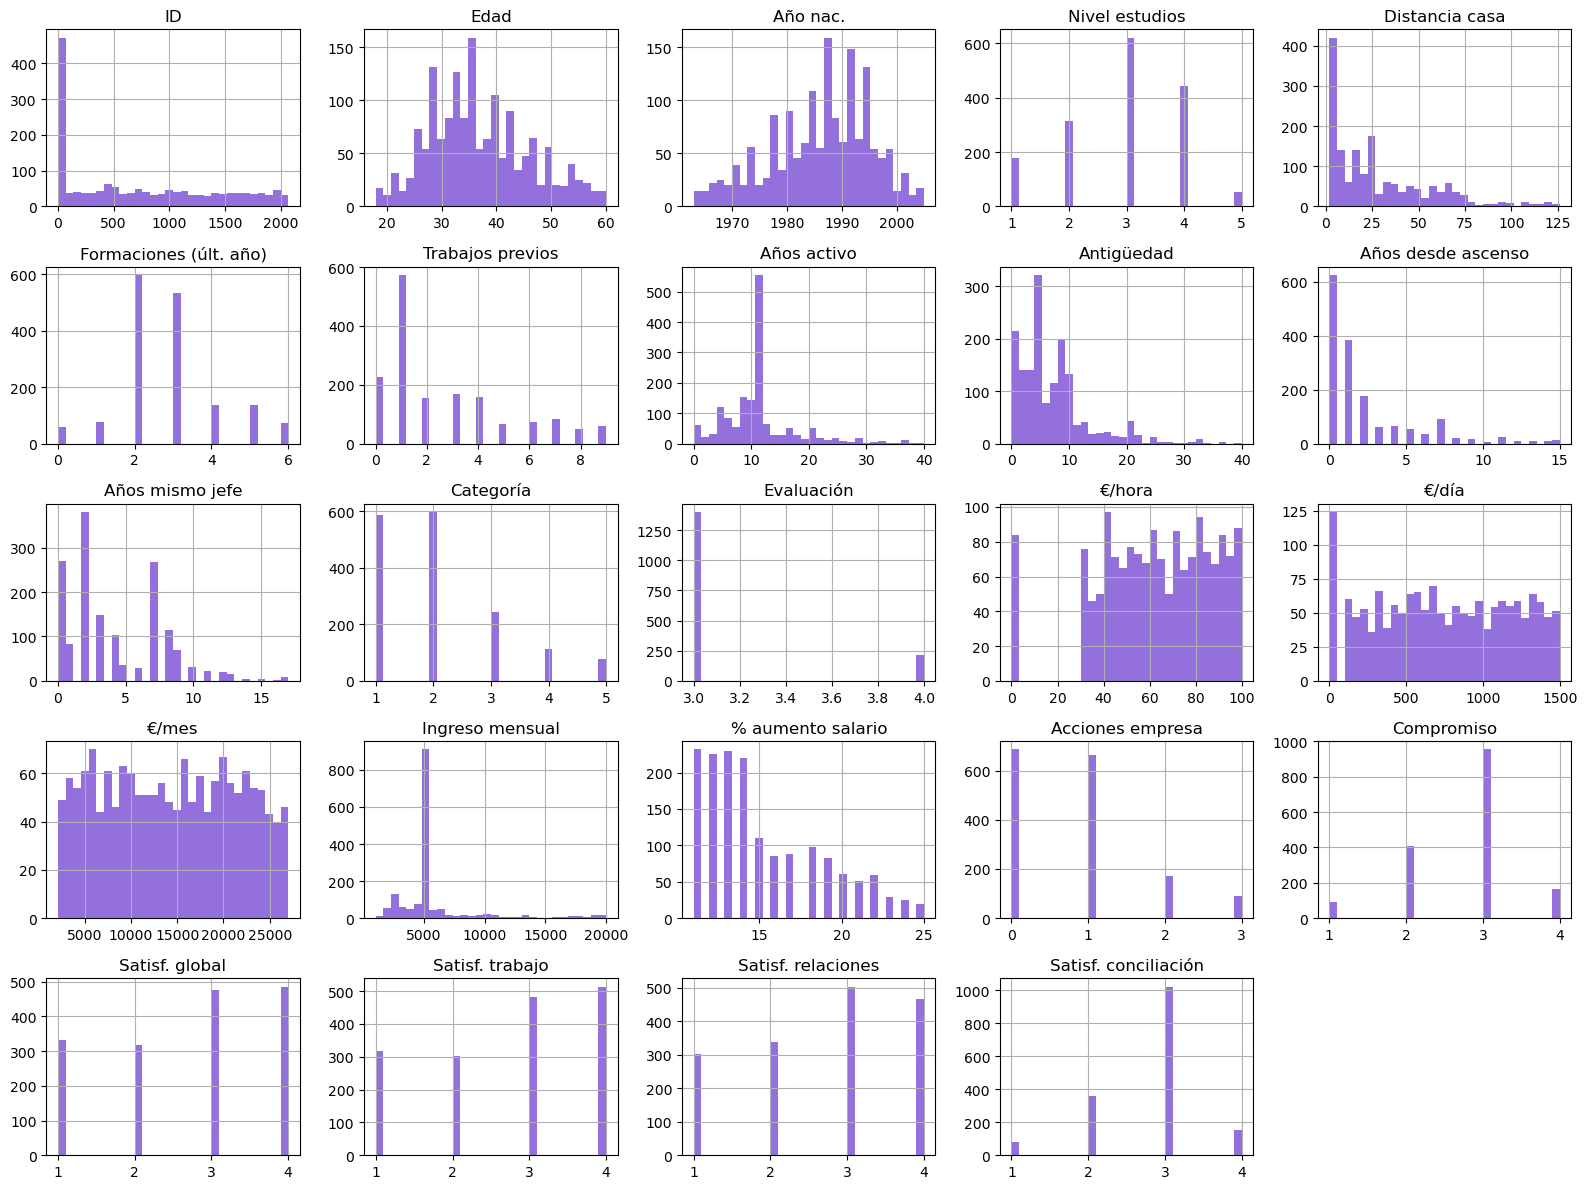

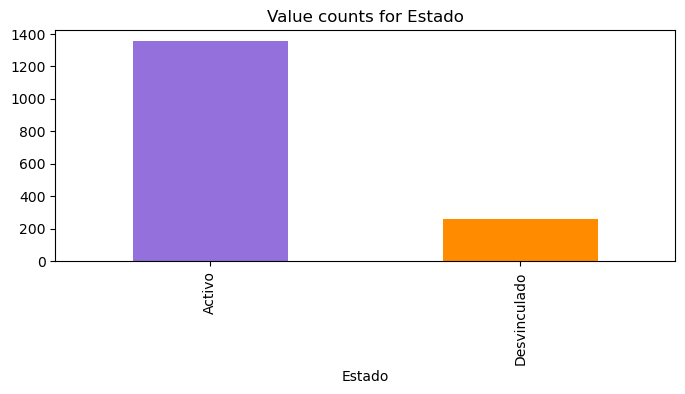

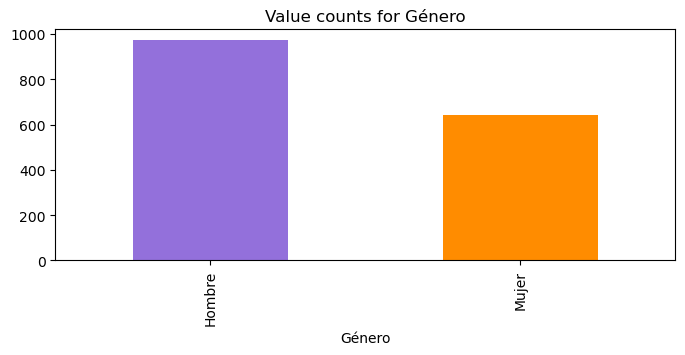

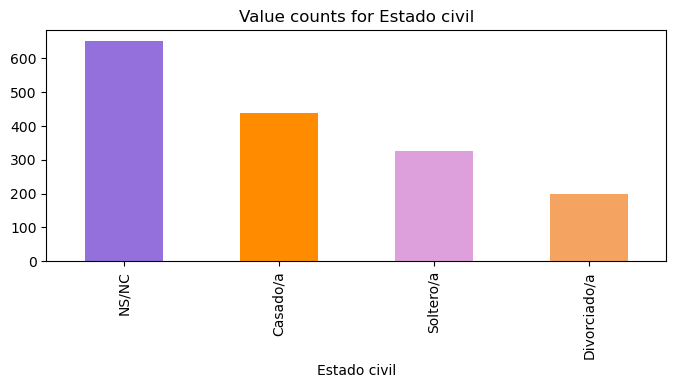

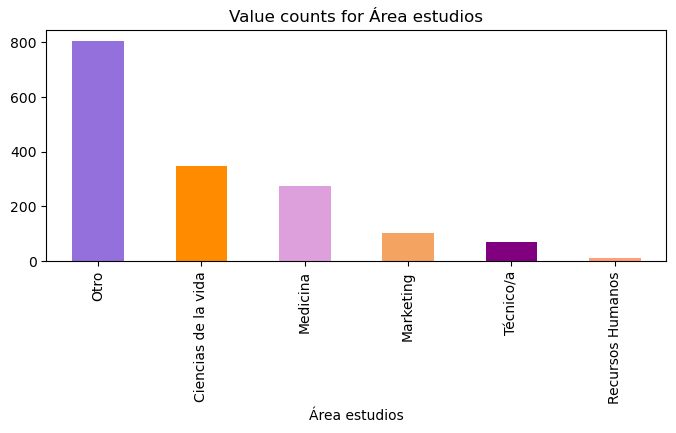

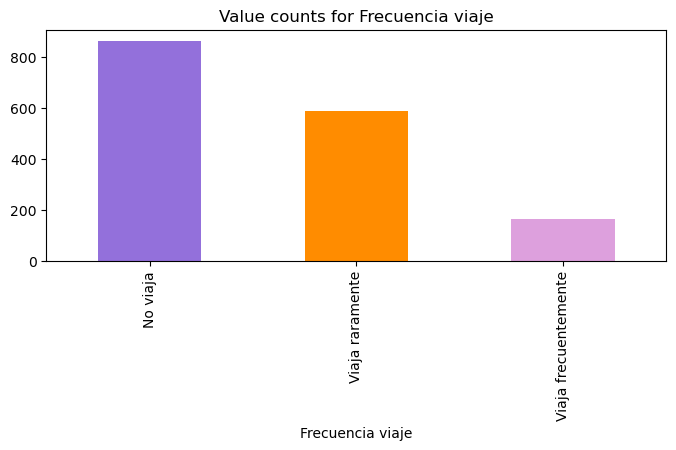

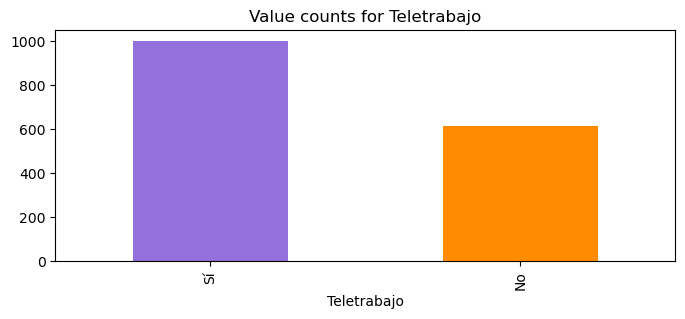

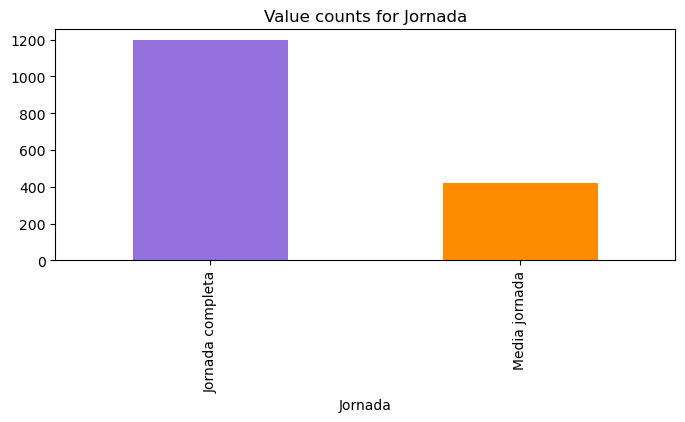

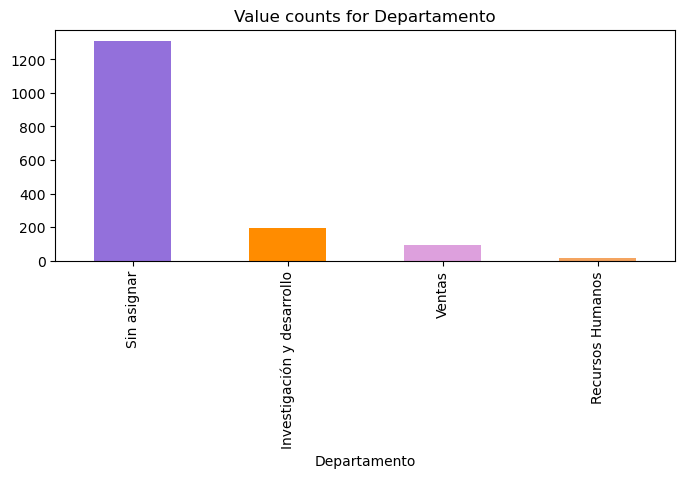

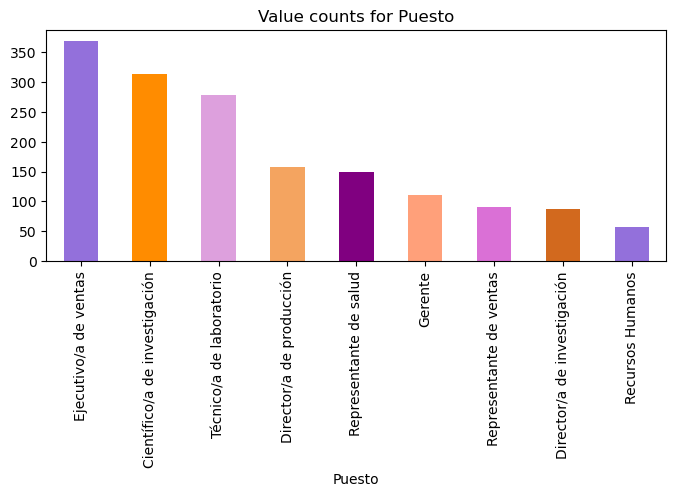

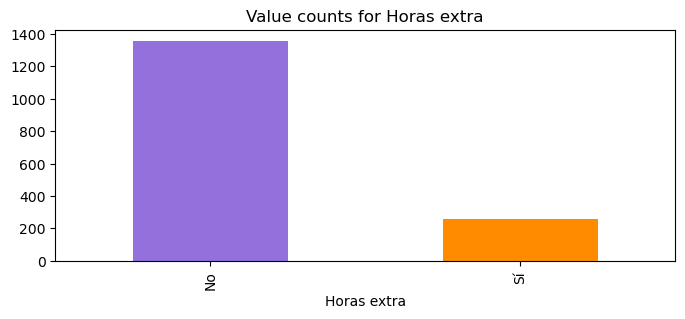

In [5]:
# Histograma para valorar las columnas numéricas
df.select_dtypes(include=[np.number]).hist(figsize=(16,12), bins=30, color = colores_proyecto[0])
# Selecciona todas las columnas numéricas y genera histogramas con 30 bins y color definido

plt.tight_layout()
# Ajusta automáticamente el espacio entre subgráficos para que no se solapen

plt.show()
# Muestra los histogramas en pantalla


# Barplots para valorar las columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
# Extrae la lista de columnas categóricas (tipo object) del DataFrame

for col in cat_cols:
    plt.figure(figsize=(8,3))
    # Crea una nueva figura para cada gráfica con tamaño 8x3

    df[col].value_counts(dropna=False).plot(kind='bar', color = colores_proyecto)
    # Cuenta los valores únicos (incluyendo NaNs) y los representa en un gráfico de barras con el color definido

    plt.title(f'Value counts for {col}')
    # Añade un título al gráfico indicando la columna analizada

    plt.show()
    # Muestra el gráfico antes de pasar a la siguiente columna

###### **GRÁFICO 1:**

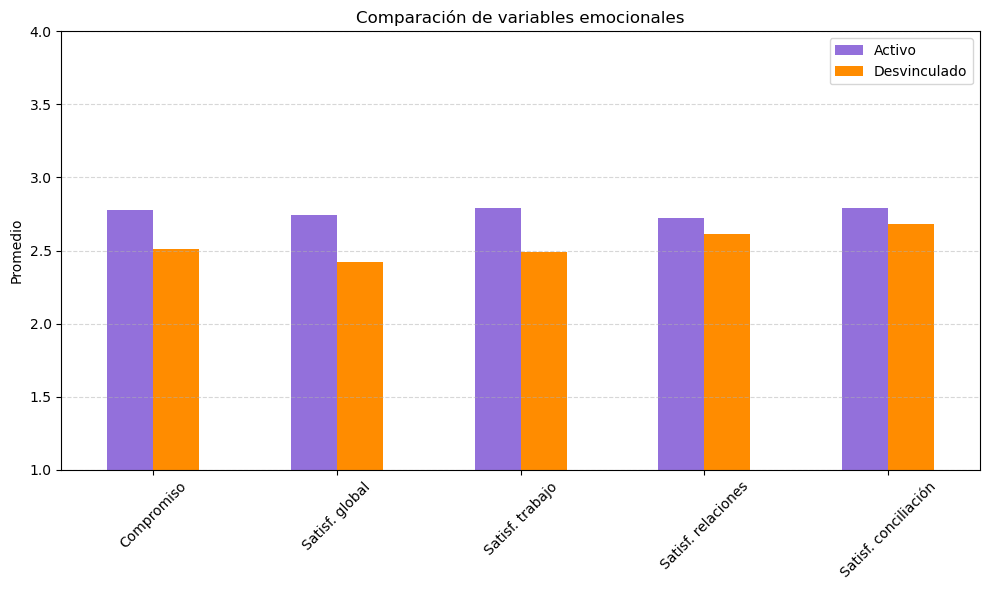

In [6]:
# Comparación de variables emocionales

variables_emocionales = ['Compromiso', 'Satisf. global', 'Satisf. trabajo', 'Satisf. relaciones','Satisf. conciliación']
# Lista con las columnas que contienen las variables emocionales a analizar

df_emocionales = (df.groupby('Estado')[variables_emocionales].mean()).round(2).T
# Agrupa el DataFrame por 'Estado', calcula la media de las variables emocionales,
# redondea a dos decimales y transpone para facilitar el plot

df_emocionales.columns = ["Activo", "Desvinculado"]
# Renombra las columnas resultantes para mayor claridad

df_emocionales.plot(kind='bar', figsize=(10,6), color=colores_proyecto)
# Genera un gráfico de barras con tamaño 10x6 y colores definidos

plt.title("Comparación de variables emocionales")
# Añade título al gráfico

plt.ylabel("Promedio")
# Etiqueta del eje Y indicando que los valores son promedios

plt.xticks(rotation=45)
# Rota las etiquetas del eje X 45 grados para mejor legibilidad

plt.legend()
# Muestra la leyenda para distinguir entre 'Activo' y 'Desvinculado'

plt.grid(axis='y', linestyle='--', alpha=0.5)
# Añade líneas de cuadrícula horizontales con estilo punteado y transparencia

plt.tight_layout()
# Ajusta el layout para evitar que los elementos se solapen

plt.ylim([1,4])
# Limita el eje Y entre 1 y 4 para mejorar la visualización

plt.show()
# Muestra el gráfico en pantalla

Conclusiones: 
  
  En la encuesta de satisfacción podemos l@s trabajador@s desvinculad@s se encontraban menos satisfechos con los diferentes ámbitos de su empresa que los empleados que continuan activos, generando por ello un compromiso menor

###### **GRÁFICO 2:**

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\3297138399.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Estado", y=col, ax=axes[i], palette = colores_proyecto)
C:\Users\almue\AppData\Local\Temp\ipykernel_4816\3297138399.py:14: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(data=df, x="Estado", y=col, ax=axes[i], palette = colores_proyecto)
C:\Users\almue\AppData\Local\Temp\ipykernel_4816\3297138399.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Estado", y=col, ax=axes[i], palette = colores_proyecto)
C:\Users\almue\AppData\Local\Temp\ipykernel_4816\3297138399.py:14: UserWarning: The palette l

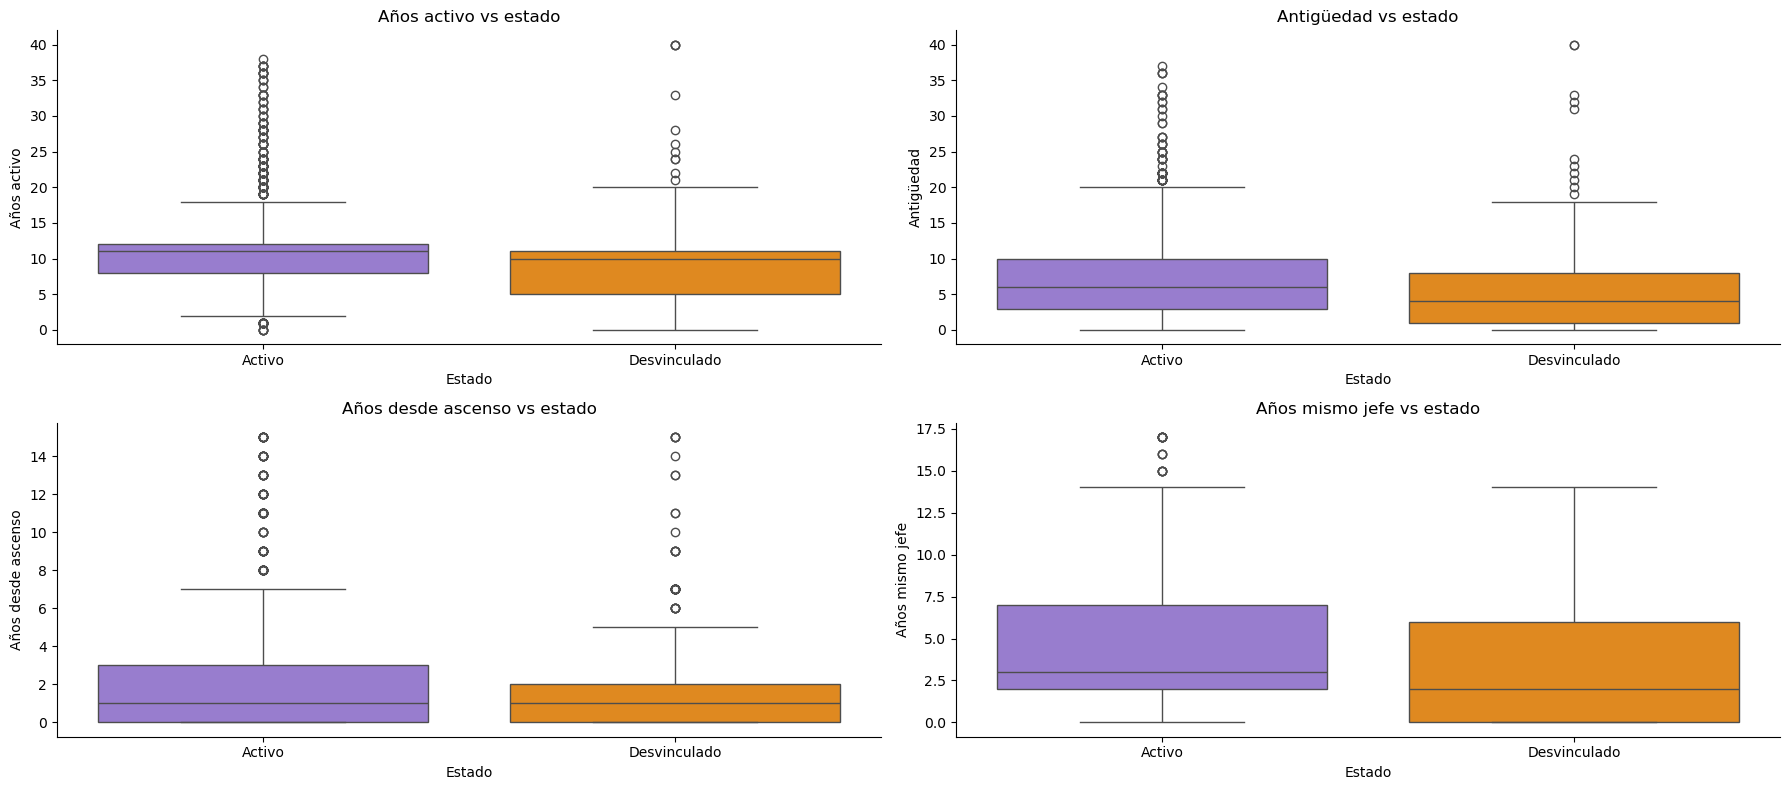

In [7]:
# Valoración historia laboral

fig, axes = plt.subplots(2, 2, figsize=(18, 8))  # altura aumentada para que no se solapen
# Crea una figura con una cuadrícula de 2 filas x 2 columnas para 4 gráficos
# El tamaño total es ancho 18 y alto 8 para evitar solapamientos

columnas = ["Años activo", "Antigüedad", "Años desde ascenso", "Años mismo jefe"]
# Lista con los nombres de las columnas a graficar

axes = axes.flatten()  # convierte la matriz 2x2 en una lista de 4 ejes
# Facilita el acceso a cada subplot con índices 0 a 3

for i, col in enumerate(columnas):
    sns.boxplot(data=df, x="Estado", y=col, ax=axes[i], palette = colores_proyecto)
    # Genera un boxplot para la columna 'col' agrupado por 'Estado' en el subplot correspondiente

    axes[i].set_title(f'{col} vs estado')
    # Establece el título del subplot

    axes[i].set_xlabel("Estado")
    # Etiqueta del eje X para cada gráfico

    axes[i].set_ylabel(col)
    # Etiqueta del eje Y con el nombre de la columna

    axes[i].spines[['right', 'top']].set_visible(False)
    # Oculta los bordes derecho y superior para un diseño más limpio

plt.tight_layout()
# Ajusta los espacios para que no se solapen los gráficos

plt.show()
# Muestra la figura con los cuatro boxplots

Conclusiones:
  
  En estas gráficas analizamos la vida laboral de los empleados en función de su estado actual. De estos datos podemos presumir que el empleado desvinculado lleva menos años en activo, tiene menos antigüedad en la empresa, no lleva mucho tiempo esperando un ascenso y lleva menos de 5 años trabajando con el mismo jefe. 

###### **GRÁFICO 3:**

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\1769679943.py:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.scatterplot(x='Antigüedad', y='Años mismo jefe', data=df_mod, palette=colores_proyecto, marker='v', hue='Estado')


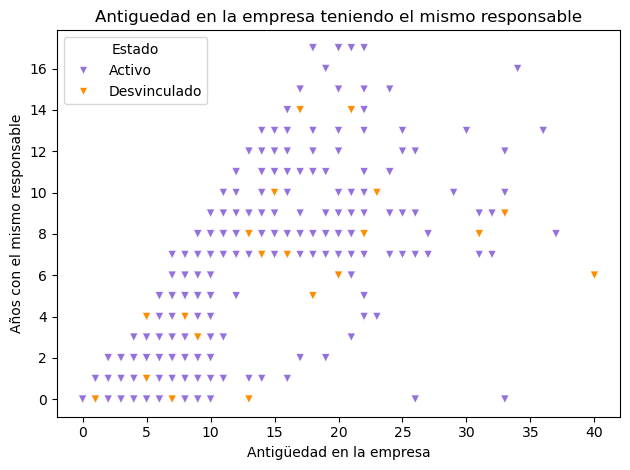

In [8]:
# Búsqueda de relación entre antigüedad, tiempo con el mismo responsable y estado

df_mod = df.copy()
# Copia el DataFrame original para evitar modificaciones directas

sns.scatterplot(x='Antigüedad', y='Años mismo jefe', data=df_mod, palette=colores_proyecto, marker='v', hue='Estado')
# Crea un gráfico de dispersión con:
# - eje X: 'Antigüedad'
# - eje Y: 'Años mismo jefe'
# - puntos con marcador en forma de 'v'
# - colores según el 'Estado' usando la paleta definida

plt.title("Antiguedad en la empresa teniendo el mismo responsable")
# Título del gráfico

plt.ylabel("Años con el mismo responsable")
# Etiqueta eje Y

plt.xlabel("Antigüedad en la empresa")
# Etiqueta eje X

plt.legend(title='Estado')
# Muestra leyenda con título para distinguir los estados

plt.gca().yaxis.set_major_locator(MultipleLocator(2))
# Ajusta el eje Y para que las marcas principales estén cada 2 unidades

plt.tight_layout()
# Ajusta el layout para evitar solapamientos

plt.show()
# Muestra el gráfico

Conclusiones:
  
  En este gráfico analizamos la cantidad de tiempo que pasan los trabajadores en la empresa y el tiempo en el que se mantienen con el mismo responsable. Por el comportamiento de los datos, podemos intuir que tiene algo de relación pero este dato no parece afectar significativamente a la marcha de los trabajadores. 

###### **GRÁFICO 4:**

In [9]:
df1 = df.copy()
df1['Estado'] = df1['Estado'].replace({'Desvinculado': 1, 'Activo': 0}).astype(int)

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\43813837.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Estado'] = df1['Estado'].replace({'Desvinculado': 1, 'Activo': 0}).astype(int)


C:\Users\almue\AppData\Local\Temp\ipykernel_4816\958349454.py:19: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(


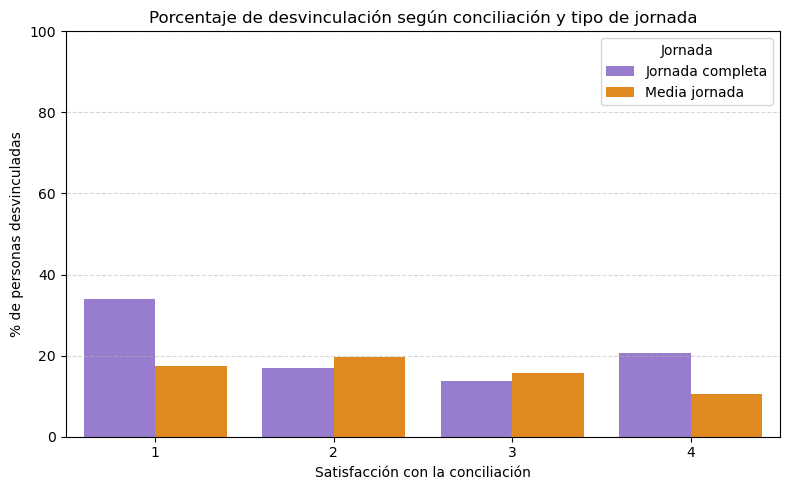

In [10]:
# Valoración de la conciliación respecto a la desvinculación

# Creamos una copia del DataFrame original para no modificar los datos base
df2 = df1.copy()

# Eliminamos las filas que tengan valores nulos en las columnas necesarias para el análisis
df2 = df2.dropna(subset=['Satisf. conciliación', 'Estado', 'Jornada'])

# Agrupamos por satisfacción con la conciliación y tipo de jornada,
# y calculamos la media de 'Estado' (donde 1 = desvinculado, 0 = activo)

df_grouped = df2.groupby(['Satisf. conciliación', 'Jornada'])['Estado'].mean().reset_index()

# Convertimos la proporción (0-1) a porcentaje (0-100)
df_grouped['% Desvinculados'] = df_grouped['Estado'] * 100

# Creamos la figura y el gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_grouped,
    x='Satisf. conciliación',
    y='% Desvinculados',
    hue='Jornada',
    palette=colores_proyecto
)

# Etiquetas y título
plt.title('Porcentaje de desvinculación según conciliación y tipo de jornada')
plt.ylabel('% de personas desvinculadas')
plt.xlabel('Satisfacción con la conciliación')

# Límites del eje Y y estilo de rejilla
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Ajuste automático del diseño
plt.tight_layout()

# Mostramos el gráfico
plt.show()

Conclusiones:
  
  Aunque no vemos una tendencia muy clara, sí que parece que el mayor porcentaje de desvinculados tienen jornada completa valorando negativamente la conciliación. 

###### **GRÁFICO 5:**

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\2658037981.py:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(


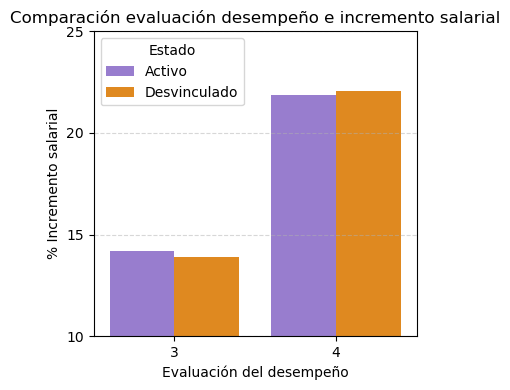

In [11]:
# Comparación evaluación desempeño e incremento salarial - no afecta a desvinculado

df_agrupado = df.groupby(["Evaluación", "Estado"], as_index=False)["% aumento salario"].mean()
# Agrupa el DataFrame por "Evaluación" y "Estado" y calcula la media del "% aumento salario" para cada grupo
# as_index=False mantiene las columnas "Evaluación" y "Estado" como columnas normales en el resultado

# Gráfico
plt.figure(figsize=(4, 4))
# Crea una figura pequeña para el gráfico

sns.barplot(
    data=df_agrupado,             # Usa el DataFrame agrupado para graficar
    x="Evaluación",               # Eje X con la evaluación del desempeño
    y="% aumento salario",        # Eje Y con el porcentaje promedio de aumento salarial
    hue="Estado",                 # Divide las barras según el estado (ej. Activo o Desvinculado)
    palette= colores_proyecto     # Usa la paleta de colores personalizada
)

# Estética
plt.title("Comparación evaluación desempeño e incremento salarial")  # Título del gráfico
plt.ylabel("% Incremento salarial")                                  # Etiqueta eje Y
plt.xlabel("Evaluación del desempeño")                              # Etiqueta eje X
plt.ylim(10, 25)                                                    # Limita eje Y entre 10 y 25 para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.5)                      # Añade líneas de cuadrícula horizontales con estilo punteado y transparencia
plt.legend(title="Estado")                                         # Muestra leyenda con título "Estado"
plt.gca().yaxis.set_major_locator(MultipleLocator(5))              # Configura que las marcas del eje Y sean cada 5 unidades
plt.tight_layout()                                                 # Ajusta el layout para evitar solapamientos
plt.show()                                                        # Muestra el gráfico

Conclusiones:
  
  De este gráfico sacamos que la empresa está reconociendo económicamente a los trabajadores en función de su desempeño y esto no parece suponer un motivo de desvinculación. 


##### **Perfil desvinculado:**


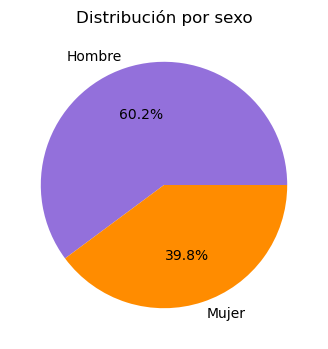

In [12]:
# En función del género:
# Calcula el porcentaje que representa cada género en todo el DataFrame
porcentaje_por_genero = df['Género'].value_counts(normalize=True) * 100

# Crea una figura para el gráfico circular con tamaño 4x4 pulgadas
plt.figure(figsize=(4, 4))

# Dibuja un gráfico de pastel con los porcentajes, etiquetas y colores personalizados
plt.pie(
    porcentaje_por_genero,                    # Valores a mostrar
    labels=porcentaje_por_genero.index,      # Etiquetas de cada sector (géneros)
    autopct='%1.1f%%',                       # Mostrar porcentaje con un decimal
    colors=colores_proyecto                   # Paleta de colores definida previamente
)

# Título del gráfico
plt.title("Distribución por sexo")

# Muestra el gráfico
plt.show()

Conclusiones:

  Tras analizar el género de los trabajadores, vemos que es mayoritariamente masculina con un 60%

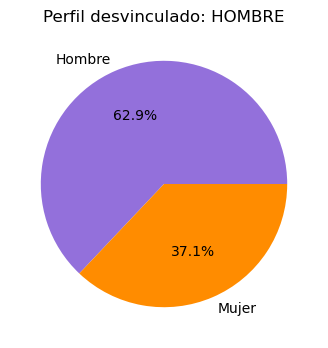

In [13]:
# En función del género:
# Filtrar el DataFrame para obtener solo los empleados desvinculados
df_filtrado = df[df['Estado'] == "Desvinculado"]
# Calcula el porcentaje que representa cada género dentro de los desvinculados
porcentaje_por_genero = df_filtrado['Género'].value_counts(normalize=True) * 100
# Crea una figura para el gráfico circular con tamaño 4x4 pulgadas
plt.figure(figsize=(4, 4))
# Dibuja un gráfico de pastel con los porcentajes, etiquetas y colores personalizados
plt.pie(porcentaje_por_genero, labels=porcentaje_por_genero.index, autopct='%1.1f%%', colors=colores_proyecto)
# Título del gráfico
plt.title("Perfil desvinculado: HOMBRE")
# Muestra el gráfico
plt.show()

Conclusiones:
 
  Si hacemos zoom a los trabajadores desvinculados, vemos que el porcentaje se mantiene, siendo en un 62% de las personas que dejan la empresa, varones. 

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\3082623095.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df_filtrado['Edad'], palette=colores_proyecto, width=0.3)
C:\Users\almue\AppData\Local\Temp\ipykernel_4816\3082623095.py:12: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.boxplot(y=df_filtrado['Edad'], palette=colores_proyecto, width=0.3)


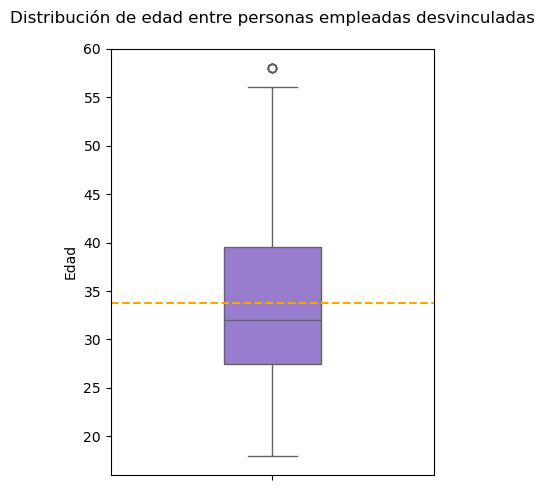

In [14]:
# En función de la edad:
# Filtra el DataFrame para quedarse solo con empleados desvinculados
df_filtrado = df[df['Estado'] == "Desvinculado"]

# Calcula la media de la edad en este grupo filtrado
media_edad = df_filtrado["Edad"].mean()

# Crea una figura para el gráfico con tamaño 4x5 pulgadas
plt.figure(figsize=(4, 5))

# Dibuja un boxplot para mostrar la distribución de edades del grupo filtrado
sns.boxplot(y=df_filtrado['Edad'], palette=colores_proyecto, width=0.3)

# Añade una línea horizontal que marque la media de la edad
plt.axhline(media_edad, color='orange', linestyle='--', linewidth=1.5, label=f'Media: {media_edad:.1f} años')

# Añade un título descriptivo al gráfico
plt.title("Distribución de edad entre personas empleadas desvinculadas\n")

# Etiqueta el eje Y
plt.ylabel("Edad")

# Ajusta el layout para evitar que se solapen elementos del gráfico
plt.tight_layout()

# Muestra el gráfico en pantalla
plt.show()

Conclusiones:
  
  Por lo que se podría haber entendido en consultas anteriores parecía que el perfil del trabajador desvinculado era de corta edad por su menor trayectoria laboral pero la mediana y media de edad de este grupo de trabajadores se establece entre 33 y 34 años. 

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\2448056040.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df1_stats.index, y=df1_stats["mean"], palette=colores_proyecto)
C:\Users\almue\AppData\Local\Temp\ipykernel_4816\2448056040.py:10: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.barplot(x=df1_stats.index, y=df1_stats["mean"], palette=colores_proyecto)


Text(0.5, 0, 'Variables')

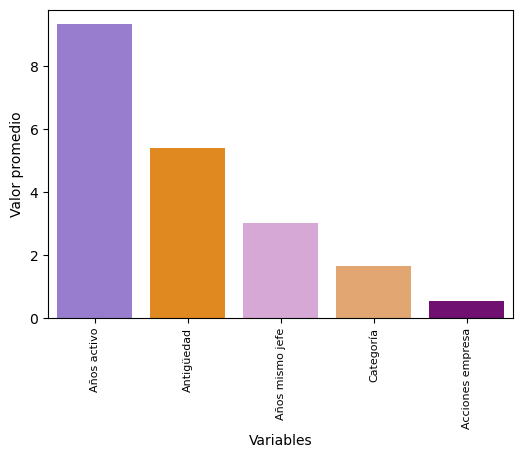

In [15]:
# Revisión otros valores medios del trabajador desvinculado

# Filtrar empleados desvinculados (Estado == 1) y calcular estadísticas descriptivas para columnas específicas
df1_stats = df1.query("Estado == 1")[['Años activo', 'Antigüedad', 'Años mismo jefe', 'Categoría', 'Acciones empresa']].describe().T

# Crear una figura para el gráfico con tamaño 6x4 pulgadas
plt.figure(figsize=(6, 4))

# Generar un gráfico de barras con los valores medios (mean) de las variables seleccionadas
sns.barplot(x=df1_stats.index, y=df1_stats["mean"], palette=colores_proyecto)

# Rotar las etiquetas del eje x 90 grados, alineadas a la derecha y con tamaño de fuente 8
plt.xticks(rotation=90, ha='right', fontsize=8)

# Ajustar las etiquetas del eje x para que estén centradas en cada barra
x_labels = df1_stats.index
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, ha='center')

# Etiqueta del eje y
plt.ylabel("Valor promedio")

# Etiqueta del eje x
plt.xlabel("Variables")

Conclusiones:
  
  Con esta tabla queremos seguir delimitando el perfil del trabajador desvinculado, que lleva de media 9 años en activo, 7 años en la propia empresa, 3 años con el mismo jefe, 2 años con la misma categoría y no parece tener mucho acceso a las acciones de la empresa. 

##### **Factores que influyen en la desvinculación:**

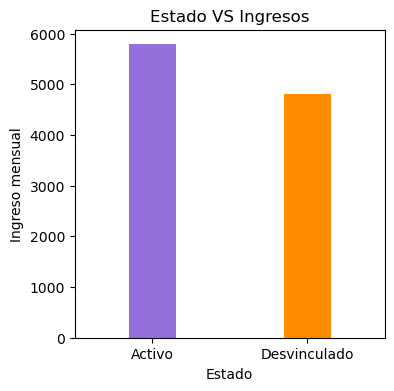

In [16]:
# INGRESOS no parece afectar a la desvinculación.

# Agrupar el DataFrame por 'Estado' y calcular la media del 'Ingreso mensual', redondeando a 2 decimales
df_ingreso = df.groupby('Estado')['Ingreso mensual'].mean().round(2)

# Crear un array con posiciones para cada barra (ejemplo: [0, 1] si hay dos estados)
x = np.arange(len(df_ingreso))

# Guardar las etiquetas (estados) para el eje x
etiquetas = df_ingreso.index

# Guardar los valores promedio de ingreso para las barras
valores = df_ingreso.values

# Crear la figura con tamaño 4x4 pulgadas
plt.figure(figsize=(4, 4))

# Graficar barras usando las posiciones x, alturas valores, colores definidos y ancho 0.3
plt.bar(x=x, height=valores, color=colores_proyecto, width=0.3)

# Poner las etiquetas en el eje x en las posiciones de x
plt.xticks(ticks=x, labels=etiquetas)

# Ajustar límites del eje x para centrar las barras en su posición
plt.xlim(-0.5, len(x) - 0.5)

# Etiqueta del eje x
plt.xlabel('Estado')

# Etiqueta del eje y
plt.ylabel('Ingreso mensual')

# Título del gráfico
plt.title('Estado VS Ingresos')

# Mostrar gráfico
plt.show()

Conclusiones:
  
  En cuanto a los ingresos, no vemos mucha diferencia entre los trabajadores activos y los desvinculados, siendo el de estos últimos algo menor pero también debemos recordar que suelen llevar menos tiempo en la empresa así que resulta más complicado que suban de categoría y de salario, en consecuencia. 

C:\Users\almue\AppData\Local\Temp\ipykernel_4816\826693189.py:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(


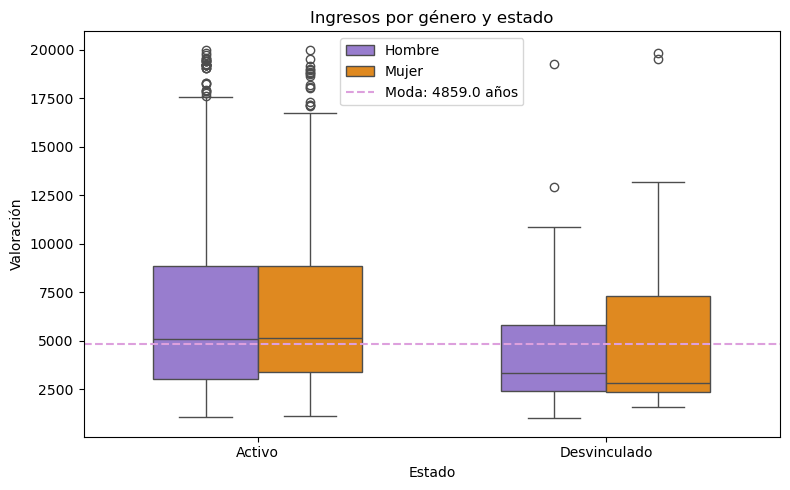

In [17]:
# Calcular la moda del ingreso mensual (valor más frecuente)
moda = df["Ingreso mensual"].mode().iloc[0]

# Filtrar el DataFrame para eliminar las filas donde el ingreso mensual es igual a la moda
df_ingresos = df[df["Ingreso mensual"] != moda]

# Crear la figura con tamaño 8x5 pulgadas
plt.figure(figsize=(8, 5))

# Crear un boxplot para ingreso mensual, separado por Estado y con hue por Género
sns.boxplot(
    x='Estado', y='Ingreso mensual', hue='Género', data=df_ingresos, 
    palette=colores_proyecto, legend=True, dodge=True, width=0.6
)
# Línea horizontal que marca la moda del ingreso mensual con estilo punteado y etiqueta
plt.axhline(moda, color="plum", linestyle='--', linewidth=1.5, label=f'Moda: {moda:.1f} años')

# Título del gráfico
plt.title("Ingresos por género y estado")

# Etiqueta eje x
plt.xlabel('Estado')

# Etiqueta eje y
plt.ylabel('Valoración')

# Ajusta el diseño para que no se solapen elementos
plt.tight_layout()

# Mostrar leyenda para la línea de la moda
plt.legend()

# Mostrar el gráfico
plt.show()

Conclusiones:
  
  Tratando de nuevo el tema de los ingresos, comprobamos si las desvinculaciones puedan deberse a que se sientan discriminados por sexo. Efectivamente, podemos ver que la mediana de estos trabajadores se encuentra muy por debajo de la media de la empresa. 

In [18]:
print(f"El percentil 25 de los trabajadores activos es {df[df["Estado"]=="Activo"]["Ingreso mensual"].quantile(0.25)}")
print(f"El percentil 50 de los trabajadores activos es {df[df["Estado"]=="Activo"]["Ingreso mensual"].quantile(0.50)}")
print(f"El percentil 75 de los trabajadores activos es {df[df["Estado"]=="Activo"]["Ingreso mensual"].quantile(0.75)}")

El percentil 25 de los trabajadores activos es 4859.0
El percentil 50 de los trabajadores activos es 4859.0
El percentil 75 de los trabajadores activos es 4876.5


<Axes: >

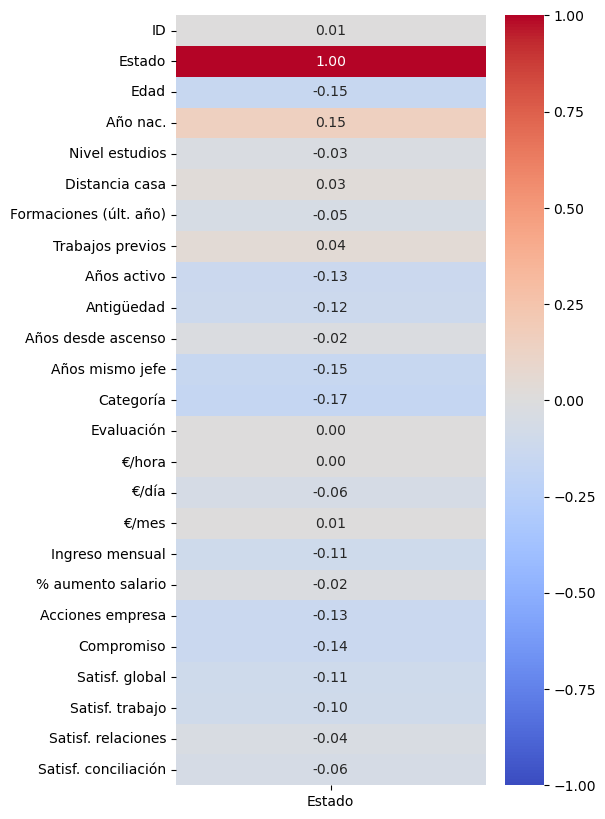

In [19]:
# Calcular la correlación entre variables numéricas y la columna 'Estado'
df_correlation = df1.select_dtypes(include="number").corr()[["Estado"]]

# Mostrar la tabla de correlaciones calculada
df_correlation

# Crear figura para el heatmap con tamaño 5x10 pulgadas
plt.figure(figsize=(5, 10))

# Crear un mapa de calor de las correlaciones con anotaciones numéricas
sns.heatmap(
    df_correlation,        # Datos de correlación
    annot=True,            # Mostrar valores numéricos en cada celda
    fmt=".2f",             # Formato de números con 2 decimales
    cmap="coolwarm",       # Paleta de colores (rojo-azul)
    vmax=1,                # Valor máximo de la escala (correlación máxima)
    vmin=-1                # Valor mínimo de la escala (correlación mínima)
)

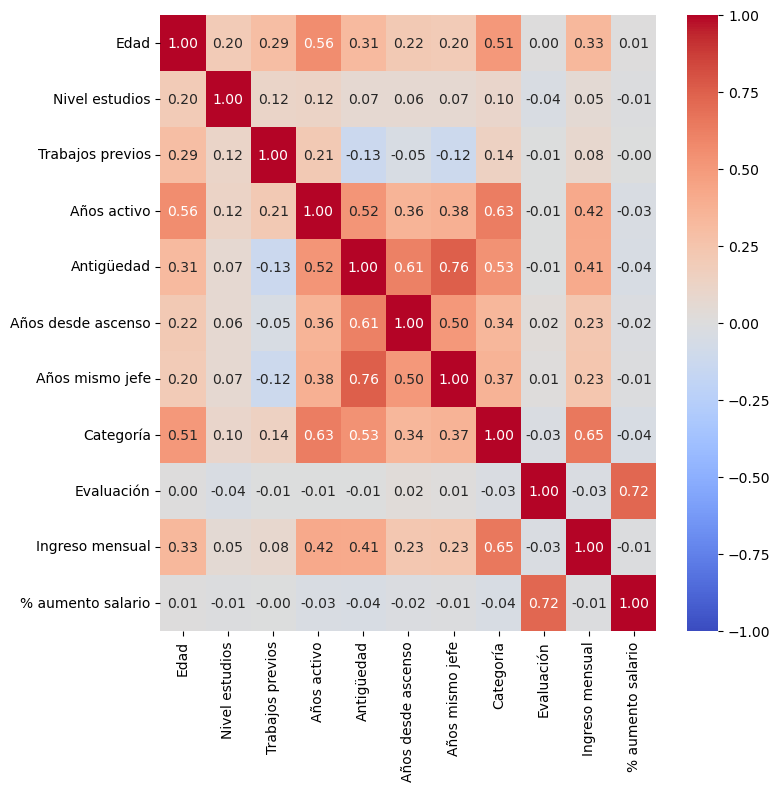

In [20]:
# MAPA de calor para valorar las variables numéricas que pueden tener relación

df_mapacalor = df[['Edad', 'Nivel estudios', 'Trabajos previos', 'Años activo',
                   'Antigüedad', 'Años desde ascenso', 'Años mismo jefe', 'Categoría',
                   'Evaluación', 'Ingreso mensual', '% aumento salario']]
# Selecciona las columnas numéricas relevantes para analizar la correlación

valores = df_mapacalor.columns
# Guarda los nombres de las columnas seleccionadas

df_correlation = df[valores].corr()
# Calcula la matriz de correlación entre esas columnas

plt.figure(figsize = (8, 8))
# Crea una figura cuadrada de tamaño 8x8 pulgadas

sns.heatmap(df_correlation,  # Dibuja el mapa de calor con las correlaciones
            annot = True,    # Muestra los valores numéricos en cada celda
            fmt = ".2f",     # Formato de los números con 2 decimales
            cmap = "coolwarm",  # Paleta de colores que va de frío a cálido
            vmax = 1,        # Valor máximo en el gradiente de color
            vmin = -1,       # Valor mínimo en el gradiente de color
            );
# La visualización permite identificar relaciones positivas o negativas fuertes entre variables